In [1]:
import pyopencl as cl
import numpy as np

ImportError: No module named 'pyopencl'

http://developer.amd.com/tools-and-sdks/opencl-zone/amd-accelerated-parallel-processing-app-sdk/

http://dhruba.name/2012/11/09/opencl-cookbook-using-amdconfigaticonfig-a-powerful-utility-in-the-amd-opencl-toolset-on-linux/

I installed amdcccle
amdconfig --list-adapters
* 0. 01:00.0 AMD Radeon 6600M and 6700M Series

* - Default adapter


It is essential to disable the crossfire:
amdconfig --adapter=0 --crossfire=off

Install the AMD APP SDK v2.9 version!!!

Reading the doc in [link](http://developer.amd.com/tools-and-sdks/opencl-zone/opencl-resources/programming-in-opencl/porting-cuda-applications-to-opencl/) gives usefull hints to translate Cuda code into OpenCL. Looking to some code helps as well.


In [2]:
import numpy as np
import pyopencl as cl

a_np = np.random.rand(50000).astype(np.float32)
b_np = np.random.rand(50000).astype(np.float32)

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

prg = cl.Program(ctx, """
__kernel void sum(__global const float *a_g, __global const float *b_g, __global float *res_g) {
  int gid = get_global_id(0);
  res_g[gid] = a_g[gid] + b_g[gid];
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
prg.sum(queue, a_np.shape, None, a_g, b_g, res_g)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

# Check on CPU with Numpy:
print(res_np - (a_np + b_np))
print(np.linalg.norm(res_np - (a_np + b_np)))

[ 0.  0.  0. ...,  0.  0.  0.]
0.0


We pass the dimension as parameter
* gridDim = get_num_groups() 
* blockDim  = get_local_size() 
* blockIdx  =  	get_group_id() 
* threadIdx  = get_local_id()

Plus we have get_global_id()  and get_global_size()  in OpenCL

Global parameters (like arrays) have to be anoted as global and constant with __global 

Apparently boolean type are not supported for data transfert because their size can be ambiguous. So we will use uchar types. As boolean are encoded on 1 byte on most of the systems it will be equivalent.

In [42]:
class GameOfLife(object):
    def __init__(self,shape):
        self.shape = shape
        self.reset()
        self.init_opencl()
        
    def reset(self):
        self.array = np.random.randint(0,2,(self.shape)).astype(np.uint8)
        
        
    def run(self,nbIteration=1):
        for i in range(nbIteration):
            self.array = self.iterate(self.array)
                
    def init_opencl(self):
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.prg = cl.Program(self.ctx,"""
            __kernel  void gol(__global unsigned char *dest,__global const unsigned char *a)
            {

                unsigned int x =   get_group_id(0) * get_local_size(0)  + get_local_id(0);
                unsigned int y =   get_group_id(1) * get_local_size(1)  + get_local_id(1);
                unsigned int nbRow = get_local_size(1) * get_num_groups(1);
                unsigned int nbCol = get_local_size(0) * get_num_groups(0);
                const unsigned int gid = x + y*nbCol;
                unsigned int N;

                if(x > 0 && y > 0 && x < nbCol-1 && y < nbRow-1){
                    N = ( a[x-1 + (y-1)*nbCol] + a[x + (y-1)*nbCol] + a[x+1 + (y-1)*nbCol] +
                          a[x-1 + ( y )*nbCol] +                    + a[x+1 + ( y )*nbCol] +
                          a[x-1 + (y+1)*nbCol] + a[x + (y+1)*nbCol] + a[x+1 + (y+1)*nbCol] );
                }else{
                    N = 0;
                }

                dest[gid] = (a[gid] & (((N==2) | (N==3)))) 
                          | (!a[gid] & N==3); 
                

            }
            """).build()

        

        #does not work with 30 (see max block size for AMD)
        self.blockSizeX = 16
        self.blockSizeY = 16
        self.nBlocksX = self.shape[1]//self.blockSizeX + (0 if self.shape[1]%self.blockSizeX == 0 else 1);
        self.nBlocksY = self.shape[0]//self.blockSizeY + (0 if self.shape[0]%self.blockSizeY == 0 else 1);



        #To optimize we are going to fill the grid and extract the data that we want.
        #We can then make the border that we want.

        self.Xtmp = np.zeros((self.blockSizeY*self.nBlocksY,self.blockSizeX*self.nBlocksX)).astype(np.uint8)
        self.Ytmp = np.zeros_like(self.Xtmp).astype(np.uint8)
    
    def iterate(self,array):   
        mf = cl.mem_flags
        self.Xtmp[...] = 0;
        self.Xtmp[0:self.shape[0],0:self.shape[1]] = array
        
        
        X_g = cl.Buffer(self.ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=self.Xtmp)
        Y_g = cl.Buffer(self.ctx, mf.WRITE_ONLY, self.Ytmp.nbytes)
        
        self.prg.gol(self.queue, self.Xtmp.shape, None, Y_g, X_g)
        
        
        
        cl.enqueue_copy(self.queue, self.Ytmp, Y_g)
        

        #self.cuda_func(
        #        drv.Out(Ytmp), drv.In(Xtmp),self.nbThreadX,self.nbThreadY,
        #        block=(self.blockSizeX,self.blockSizeY,1), grid=(self.nBlocksX,self.nBlocksY))
        
        
        Y = self.Ytmp[0:self.shape[0],0:self.shape[1]]

        return Y


In [55]:
gol = GameOfLife((10000,10000))

In [56]:
%timeit gol.run()

1 loops, best of 3: 228 ms per loop


In [38]:
import unittest
import numpy.testing as npt
class TestGameOfLife(unittest.TestCase):
    def setUp(self):
        self.shape = (6,6)
        self.uut = GameOfLife(self.shape)
        
    def testUpdate(self):
        a = np.array([
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,1,1,1,0],
                [0,1,1,1,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]
            ]).astype(np.bool_)
        self.uut.array = a
        b = np.array([
                [0,0,0,0,0,0],
                [0,0,0,1,0,0],
                [0,1,0,0,1,0],
                [0,1,0,0,1,0],
                [0,0,1,0,0,0],
                [0,0,0,0,0,0]
            ]).astype(np.bool_)
        
        self.uut.run()
        npt.assert_equal(self.uut.array,b)
        self.uut.run()
        npt.assert_equal(self.uut.array,a)
        
import sys
def runGOFTest():
    suite = unittest.TestLoader().loadTestsFromTestCase(TestGameOfLife)
    unittest.TextTestRunner().run(suite)

In [47]:
runGOFTest()

.
----------------------------------------------------------------------
Ran 1 test in 0.009s

OK


In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [58]:
def plotArray(array):
    X = np.copy(array)
    plt.imshow(X,cmap='gray_r',interpolation='none')
    
def plotIterations(gof,nbIteration=1):
    for i in range(nbIteration):
        if i != 0:
            uut.run()
            
        plt.subplot(100 + nbIteration*10+i+1)
        plotArray(uut.array)
        plt.xticks([])
        plt.yticks([])

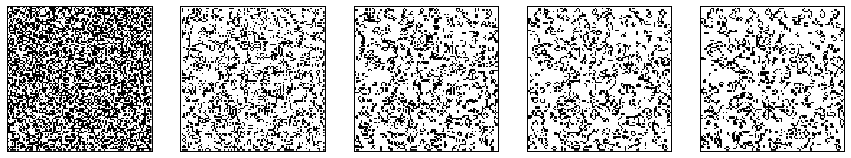

In [60]:
shape = (100,100)
uut = GameOfLife(shape)
plotIterations(uut,5)